# Import libraries and data

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=28e6a88ffd9bc0ba2cddb1266c5d6fc0bba4bd997c491f18fccd094ecf726782
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

##Data Dictionary

In [ ]:
#age | int64 | age in years

#job | object | type of job (categorical: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar' 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed' 'student']) 

#marital | object | marital status (categorical: ['married' 'single' 'divorced'])

#education | Object | education background (categorical: ['secondary' 'tertiary' 'primary' 'unknown'])

#default | Object | has credit in default? (categorical: ['no' 'yes'])

#balance | int64 | Balance of the individual

#housing | object | has housing loan? (categorical: ['yes' 'no'])

#loan | object | has personal loan? (categorical: ['no' 'yes'])

#contact | object | contact communication type (categorical: ['unknown' 'cellular' 'telephone'])

#day | int64 | last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

#month | object | last contact month of year (categorical: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'])

#duration | int64 | last contact duration, in seconds (numeric)

#campaign | int64 | number of contacts performed during this campaign and for this client

#pdays | int64 | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

#previous | int64 | number of contacts performed before this campaign and for this client

#poutcome | object | outcome of the previous marketing campaign (categorical: ['unknown' 'other' 'failure' 'success'])**

#deposit (target variable)

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv("bank.csv")
# df = pd.read_csv('/content/bank-full.csv', sep=';')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank-full.csv', sep=';')
df.rename(columns={'y':'deposit'}, inplace=True)
print(df.shape)
df.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Data Cleaning

In [ ]:
# inspect data - no null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  deposit    45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


##Numeric Columns

In [ ]:
# inspecting numeirc data

'''potential issues:
- balance less than 0 - why?
- pdays = -1 - what does it mean?
- potential outliers in balance, duration, campaign, pdays and previous
'''

df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
# checking those with balance less than 0
print(df[df['balance']<0]['balance'].count())
print(df[df['balance']<0]['balance'].value_counts())

3766
-1       50
-2       25
-3       22
-97      17
-100     16
         ..
-890      1
-901      1
-710      1
-677      1
-1414     1
Name: balance, Length: 916, dtype: int64


In [ ]:
# check those pdays =-1
# A quick check below shows for all pdays = -1, poutcome are all unknown, hence we assume -1 means 'not contacted'
df[df['pdays']<0]['pdays'].value_counts()

-1    36954
Name: pdays, dtype: int64

In [ ]:
df[df['pdays']>=0]['poutcome'].value_counts()

failure    4901
other      1840
success    1511
unknown       5
Name: poutcome, dtype: int64

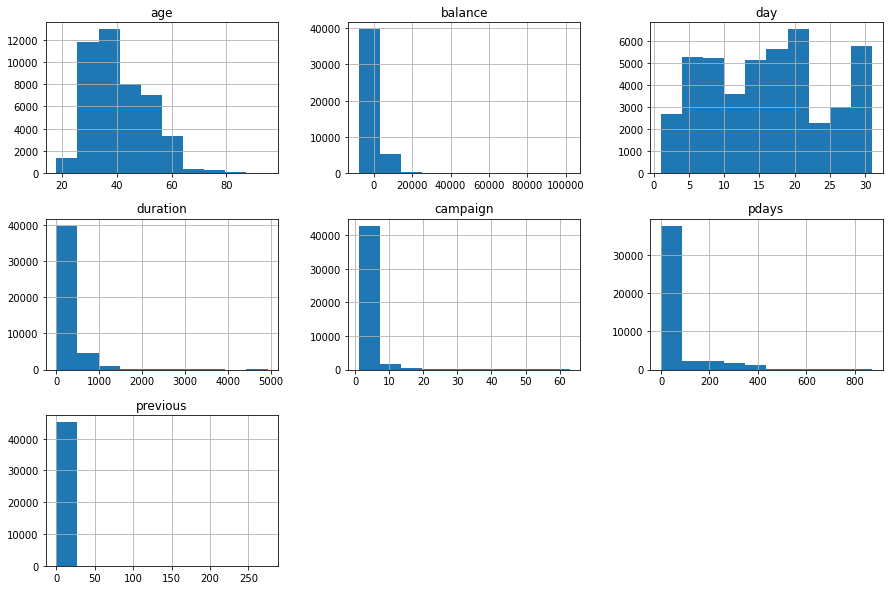

In [ ]:
# check the distribution of all continuous variable
df.hist(figsize=(15, 10))
plt.show()

In [ ]:
# Encode target values into 0 & 1
le=LabelEncoder()
df['deposit_encoded'] = le.fit_transform(df['deposit'])
df.drop(columns='deposit', inplace=True)
df['deposit_encoded'].value_counts()
# note imbalance dataset 

0    39922
1     5289
Name: deposit_encoded, dtype: int64

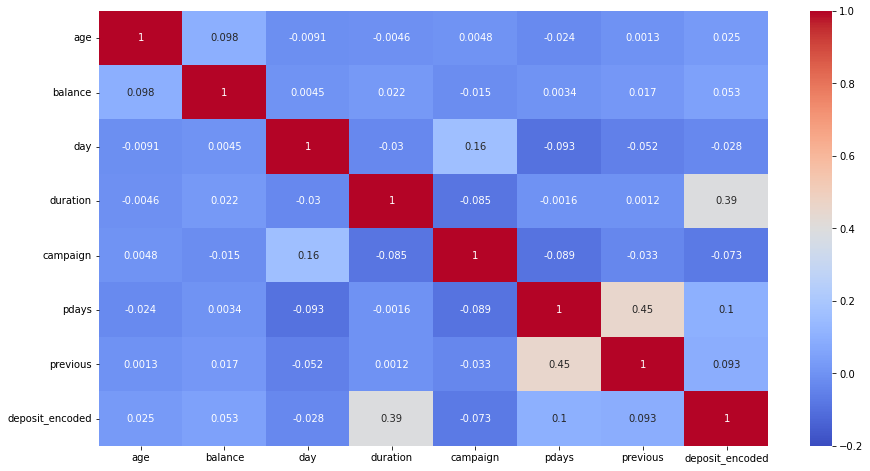

In [ ]:
# correlation matrix (original data - before any data processing)
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), cmap="coolwarm", annot = True, vmin=-0.2)
plt.show()

In [ ]:
def impute(df, col, method = 'median'):
    if method == 'median':
        imputed_value = df[col].median()
    elif method == 'mean':
        imputed_value = df[col].mean()
    else:
        imputed_value = 0
    df[col] = df[col].fillna(imputed_value)

In [ ]:
# Data processing for numeric columns
df_clean = df.copy()

# 1. impute pdays = -1 with median
df_clean.loc[df_clean['pdays']==-1,'pdays'] = np.nan
impute(df_clean, 'pdays', method = 'median')

In [ ]:
# 2. winsorization
def clip_col(df, col, quantile = 0.9, mark_clipped = True):
    quantile_value = df[col].quantile(quantile)
    if mark_clipped:
        new_col_name = col + '_is_clipped'
        df[new_col_name] = np.where(df[col]>quantile_value,1,0)
    df[col] = np.where(df[col]>quantile_value, quantile_value, df[col])

cols_to_clip = [
                'balance',
                'duration',
                'campaign',
                'previous',
                ]
for col in cols_to_clip:
    clip_col(df_clean, col)

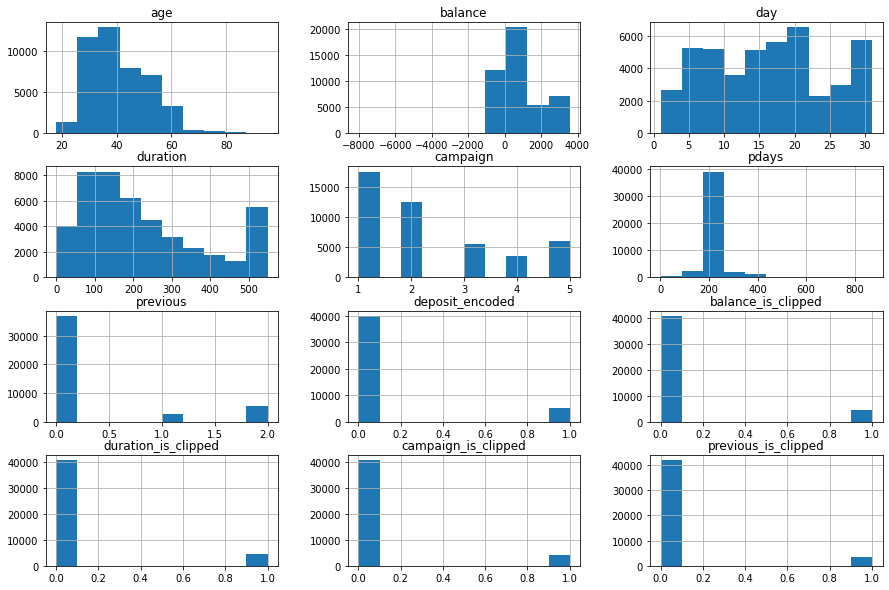

In [ ]:
# define all numeric columns
numeric_cols =  list(df_clean.select_dtypes(include='number').columns)

# plot histogram of all numeric columns (after preprocessing)
df_clean[numeric_cols].hist(figsize=(15, 10))
plt.show()

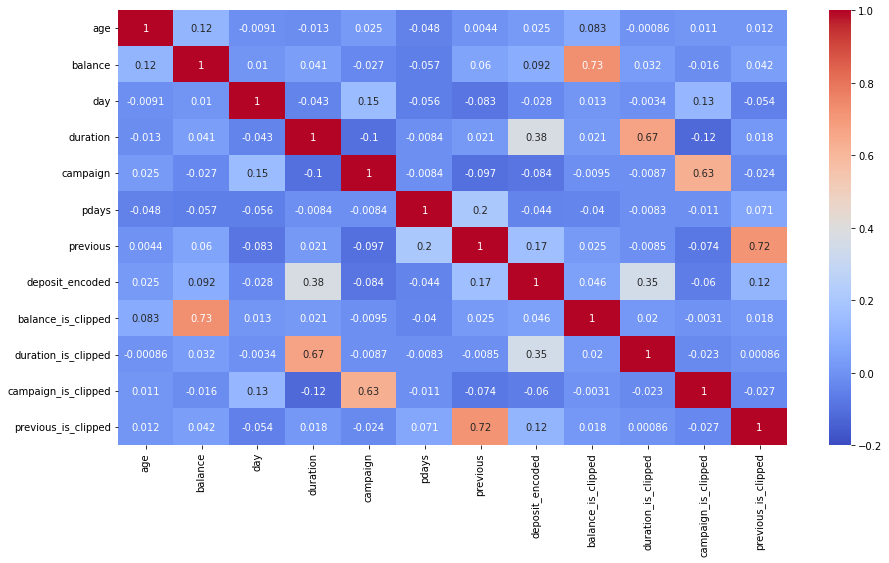

In [ ]:
# correlation matrix (after data processing)
plt.figure(figsize=(15,8))
sns.heatmap(df_clean.corr(), cmap="coolwarm", annot = True, vmin=-0.2)
plt.show()

In [ ]:
# Spearman's Rank Correlation Test (independent vs dependent variable)
from scipy.stats import pearsonr
for c in numeric_cols:
  stat, p = pearsonr(df_clean[c], df_clean['deposit_encoded'])
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Correlation between {} and {} is insignificant'.format(c, 'deposit_encoded'))
  else:
    print('Correlation between {} and {} is significant'.format(c, 'deposit_encoded'))

# all significant

stat=0.025, p=0.000
Correlation between age and deposit_encoded is significant
stat=0.092, p=0.000
Correlation between balance and deposit_encoded is significant
stat=-0.028, p=0.000
Correlation between day and deposit_encoded is significant
stat=0.376, p=0.000
Correlation between duration and deposit_encoded is significant
stat=-0.084, p=0.000
Correlation between campaign and deposit_encoded is significant
stat=-0.044, p=0.000
Correlation between pdays and deposit_encoded is significant
stat=0.165, p=0.000
Correlation between previous and deposit_encoded is significant
stat=1.000, p=0.000
Correlation between deposit_encoded and deposit_encoded is significant
stat=0.046, p=0.000
Correlation between balance_is_clipped and deposit_encoded is significant
stat=0.350, p=0.000
Correlation between duration_is_clipped and deposit_encoded is significant
stat=-0.060, p=0.000
Correlation between campaign_is_clipped and deposit_encoded is significant
stat=0.123, p=0.000
Correlation between previou

## Exploratory Data Analysis

In [ ]:
# success rate (Out of all contacted customer, how many % subscribed)

df_clean[df_clean['pdays']>0]['deposit_encoded'].value_counts(normalize=True)

# Success rate is only 11.7%

0    0.883015
1    0.116985
Name: deposit_encoded, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text major ticklabel objects>)

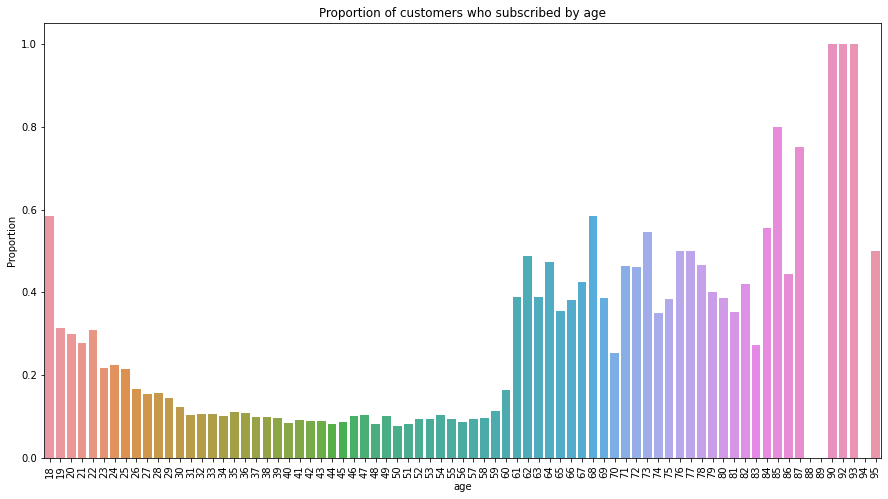

In [ ]:
df_plot.reset_index(inplace=True)
df_plot = df_plot.rename(columns={0: "no_deposit", 1: "deposit"})
df_plot['Proportion'] = df_plot['deposit'].div(df_plot['no_deposit']+df_plot['deposit'])

plt.figure(figsize=(15,8))
sns.barplot(data=df_plot,x='age',y='Proportion')
plt.title('Proportion of customers who subscribed by age')
plt.xticks(rotation=90)

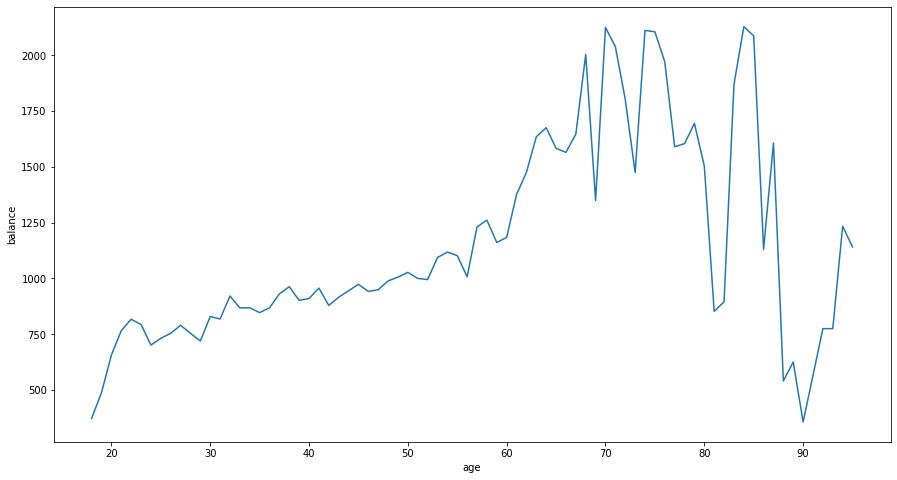

In [ ]:
# average balance by ages (all data)
df_clean_by_age = df_clean.groupby('age').mean().reset_index()
plt.figure(figsize=(15,8))
sns.lineplot(data=df_clean_by_age,x='age',y='balance')
plt.show()

# higher average balance for age 60-86

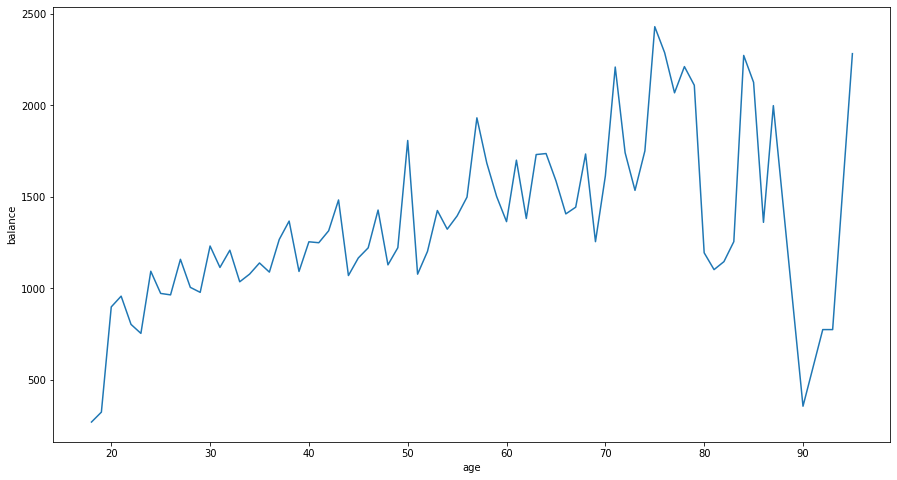

In [ ]:
# average balance by ages (selected only those who subscribed)
df_clean_by_age = df_clean[df_clean['deposit_encoded']==1].groupby('age').mean().reset_index()
plt.figure(figsize=(15,8))
sns.lineplot(data=df_clean_by_age,x='age',y='balance')
plt.show()

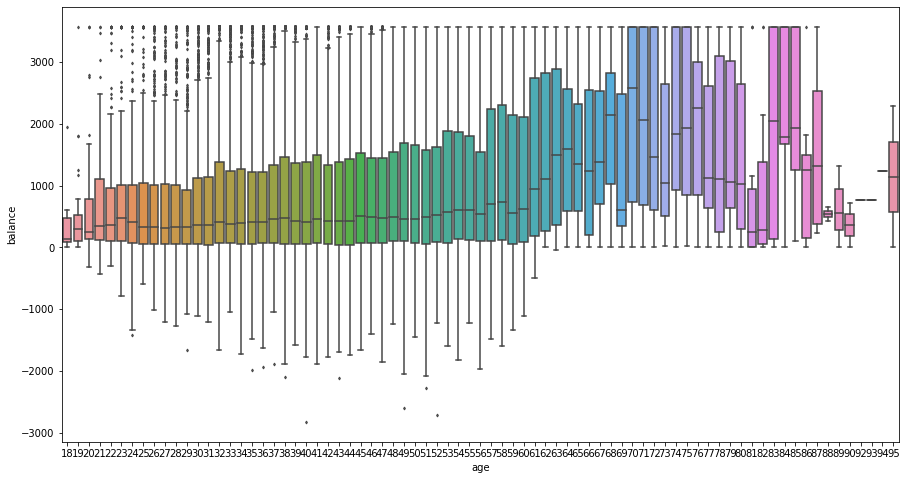

In [ ]:
# age 18 and their balance
df_age18 = df_clean.loc[(df_clean['age']>=18) & (df_clean['balance']>-3000)]
plt.figure(figsize=(15,8))
sns.boxplot(data=df_age18,x='age',y='balance',flierprops = dict(markerfacecolor = '0.50', markersize = 2))
plt.show()

# even though 18 years old are willing to subscribe, their balance is lower as compared to age >60, hence first priority should be age >60.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


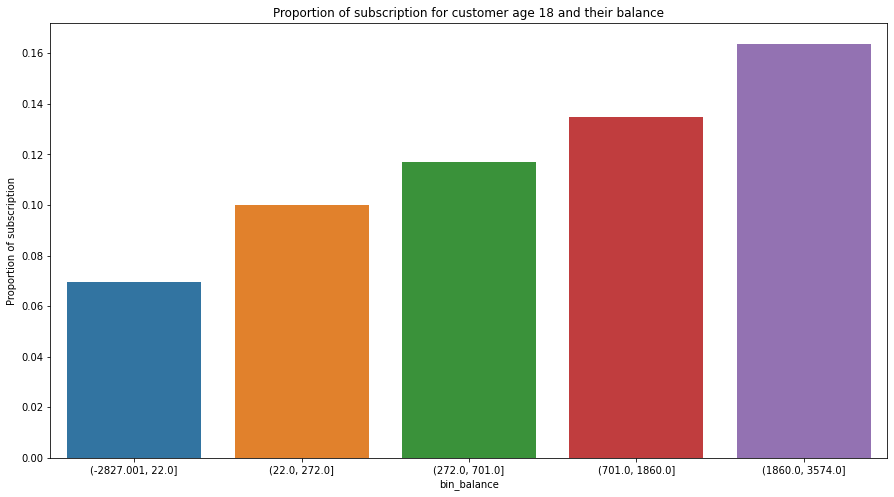

In [ ]:
df_age18['bin_balance'] = pd.qcut(df_age18['balance'],q=5)
df_age18 = df_age18.groupby('bin_balance').mean().reset_index()

plt.figure(figsize=(15,8))
p = sns.barplot(data=df_age18,x='bin_balance',y='deposit_encoded')
plt.title('Proportion of subscription for customer age 18 and their balance')
p.set_ylabel('Proportion of subscription')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


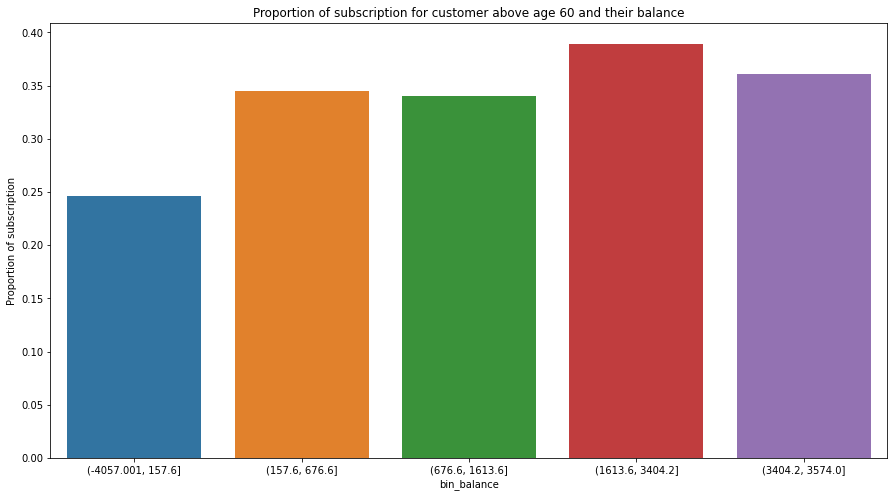

In [ ]:
df_age60above = df_clean.loc[df_clean['age']>=60]
df_age60above['bin_balance'] = pd.qcut(df_age60above['balance'],q=5)
df_age60above = df_age60above.groupby('bin_balance').mean().reset_index()
plt.figure(figsize=(15,8))
p = sns.barplot(data=df_age60above,x='bin_balance',y='deposit_encoded')
plt.title('Proportion of subscription for customer above age 60 and their balance')
p.set_ylabel('Proportion of subscription')

plt.show()

Text(0.5, 1.0, 'Proportion of customers who subscribed by balance')

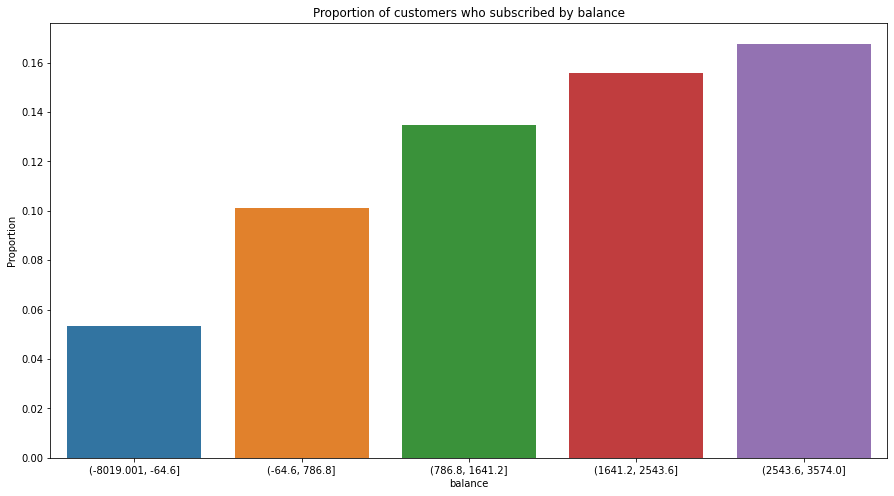

In [ ]:
df_plot_bal = df_clean.groupby(['balance', 'deposit_encoded']).size().reset_index().pivot_table(columns='deposit_encoded',index='balance', values=0, fill_value=0)

df_plot_bal = df_plot_bal.reset_index()
df_plot_bal['balance'] = pd.qcut(df_plot_bal['balance'],q=5)
df_plot_bal = df_plot_bal.groupby(['balance']).sum()
df_plot_bal = df_plot_bal.rename(columns={0: "no_deposit", 1: "deposit"})
df_plot_bal['Proportion'] = df_plot_bal['deposit'].div(df_plot_bal['no_deposit']+df_plot_bal['deposit'])
df_plot_bal = df_plot_bal.reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=df_plot_bal,x='balance',y='Proportion')
plt.title('Proportion of customers who subscribed by balance')

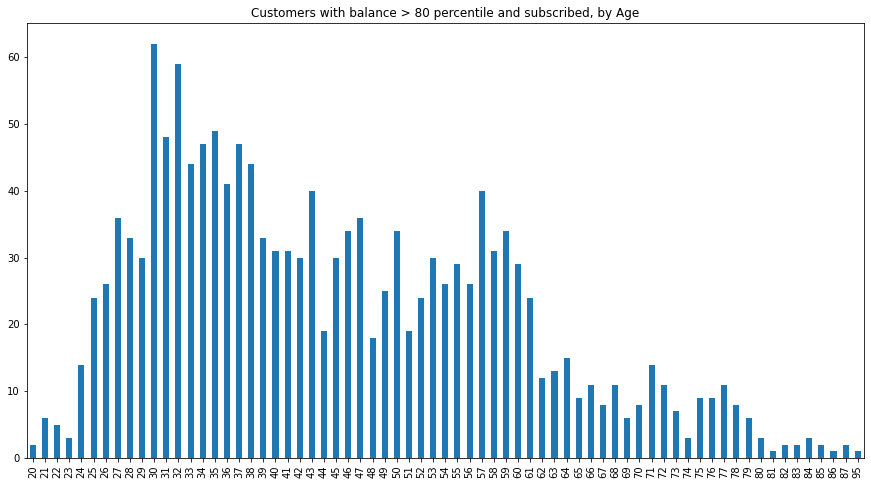

In [ ]:
df_80pct_balance = df_clean.loc[df_clean['balance']>=df_clean['balance'].quantile([0.8]).values[0]]
df_80pct_balance[df_80pct_balance['deposit_encoded']==1]['age'].value_counts().sort_index().plot(kind='bar', figsize=(15,8))
plt.title('Customers with balance > 80 percentile and subscribed, by Age')
plt.show()

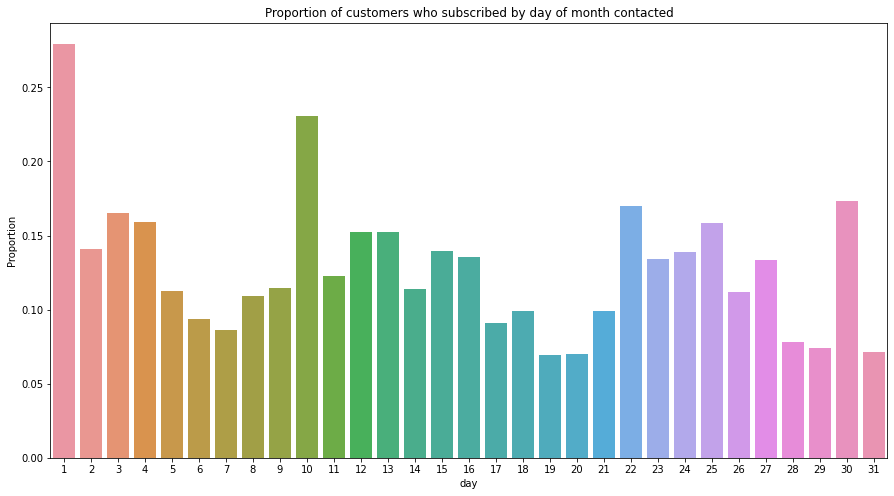

In [ ]:
df_plot_day = df_clean.groupby(['day', 'deposit_encoded']).size().reset_index().pivot_table(columns='deposit_encoded',index='day', values=0, fill_value=0)

df_plot_day = df_plot_day.reset_index()

df_plot_day = df_plot_day.rename(columns={0: "no_deposit", 1: "deposit"})
df_plot_day['Proportion'] = df_plot_day['deposit'].div(df_plot_day['no_deposit']+df_plot_day['deposit'])

plt.figure(figsize=(15,8))
sns.barplot(data=df_plot_day,x='day',y='Proportion')
plt.title('Proportion of customers who subscribed by day of month contacted')
plt.show()

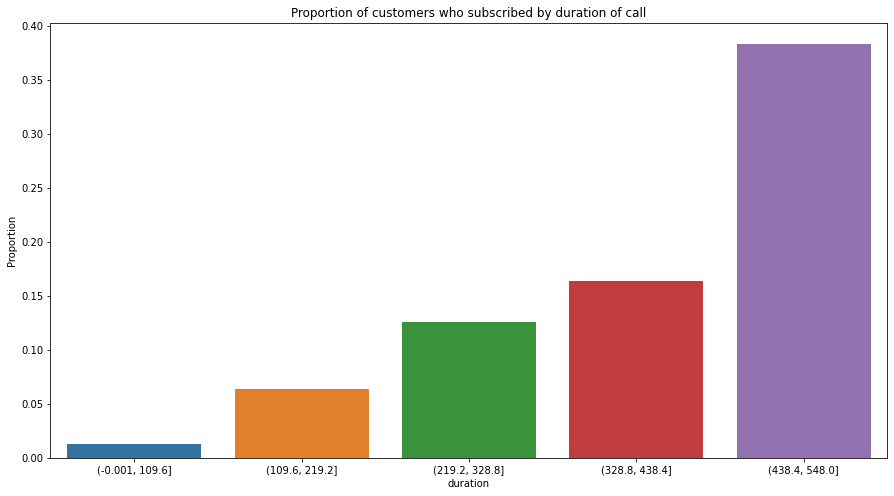

In [ ]:
df_plot_dur = df_clean.groupby(['duration', 'deposit_encoded']).size().reset_index().pivot_table(columns='deposit_encoded',index='duration', values=0, fill_value=0)

df_plot_dur = df_plot_dur.reset_index()
df_plot_dur['duration'] = pd.qcut(df_plot_dur['duration'],q=5)
df_plot_dur = df_plot_dur.groupby(['duration']).sum()
df_plot_dur = df_plot_dur.rename(columns={0: "no_deposit", 1: "deposit"})
df_plot_dur['Proportion'] = df_plot_dur['deposit'].div(df_plot_dur['no_deposit']+df_plot_dur['deposit'])
df_plot_dur = df_plot_dur.reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=df_plot_dur,x='duration',y='Proportion')
plt.title('Proportion of customers who subscribed by duration of call')
plt.show()

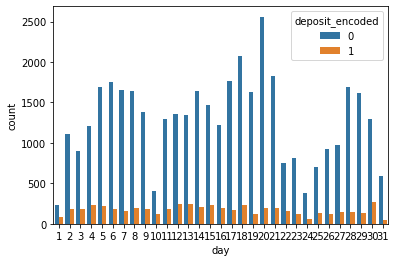

In [ ]:
# trying to find out if there is any trend in 'day'
sns.countplot(data=df_clean, x='day', hue='deposit_encoded')
plt.show()

## Categorical Columns

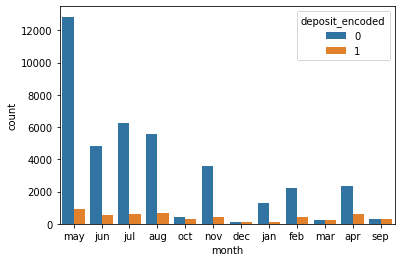

In [ ]:
# trying to find out if there is any trend in 'month'
sns.countplot(data=df_clean, x='month', hue='deposit_encoded')
plt.show()

In [ ]:
# inspecting categorical data
# shows unique values for all columns
category_cols = df_clean.select_dtypes(include='object').columns

for col in category_cols:
    print(col+':')
    print(df_clean[col].unique())

job:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital:
['married' 'single' 'divorced']
education:
['tertiary' 'secondary' 'unknown' 'primary']
default:
['no' 'yes']
housing:
['yes' 'no']
loan:
['no' 'yes']
contact:
['unknown' 'cellular' 'telephone']
month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome:
['unknown' 'failure' 'other' 'success']


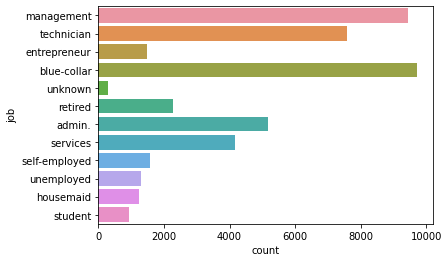

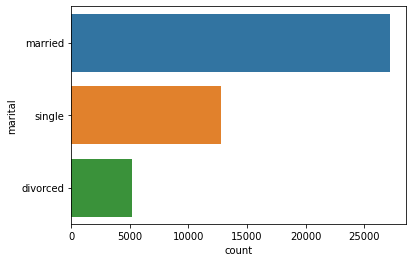

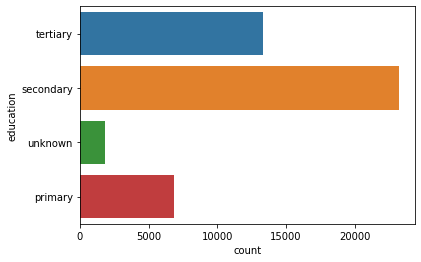

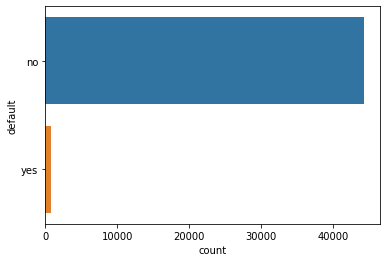

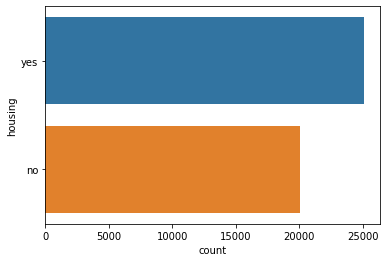

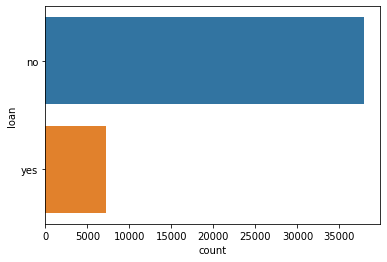

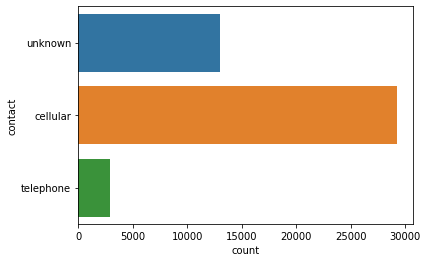

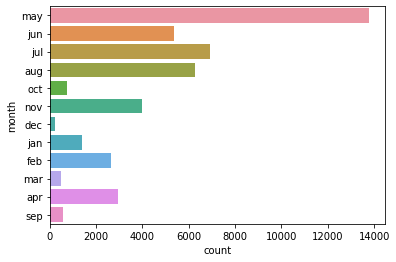

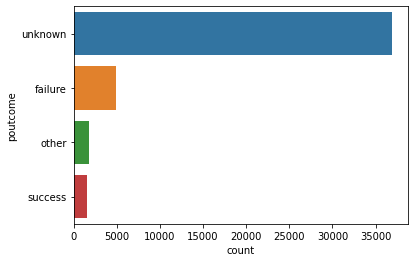

In [ ]:
for col in df.select_dtypes(include='object').columns:
    sns.countplot(y=col,data=df)
    plt.show()

In [ ]:
def ohe(df, col):
    one_hot = pd.get_dummies(df[col])
    one_hot.columns = [f'{col}_{attribute}' for attribute in one_hot.columns]
    df = df.drop(col,axis = 1)
    df = df.join(one_hot)
    return df

def label_encode(df, col):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df

In [ ]:
for col in category_cols:
    # if col!='deposit':
    df_clean = ohe(df_clean, col)

In [ ]:
numeric_cols.remove('deposit_encoded')
numeric_cols.remove('day')

scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# Model testing

In [ ]:
df_clean.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'deposit_encoded', 'balance_is_clipped', 'duration_is_clipped',
       'campaign_is_clipped', 'previous_is_clipped', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_

In [ ]:
X = df_clean.drop(columns='deposit_encoded')
y = df_clean['deposit_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=620, stratify=y)

In [ ]:
is_balanced = True
if not is_balanced:
    sampler = SMOTE()
    X_train_over, y_train_over = sampler.fit_resample(X_train, y_train)
else:
    X_train_over, y_train_over = X_train, y_train

## Test multiple models for rough accuracy before hypertuning

In [ ]:
models = {
          'LR': LogisticRegression(),
          'DT': DecisionTreeClassifier(),
        #   'KNN': KNeighborsClassifier(), #taking too long, not suitable for oversampling
          'SVC': SVC(kernel='rbf',probability=True),
         'RF': RandomForestClassifier(),
         'LGBM': LGBMClassifier()
          }

In [ ]:
# # run for around 30 minutes. Next time dont have to do this, can just upload the saved model
metric_dict = {}
for model_name, model in models.items():
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    metric_dict[model_name] = [accuracy, f1, roc_score]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
with open(r"/content/drive/MyDrive/Colab Notebooks/DSFS_models.pickle", "wb") as model_file:
    pickle.dump((models, metric_dict), model_file)

In [ ]:
# read pickle
with open('/content/drive/MyDrive/Colab Notebooks/DSFS_models.pickle', 'rb') as f:
    (models, metric_dict) = pickle.load(f)

In [ ]:
# run for around 20 minutes. Next time dont have to do this, can just upload the saved model
metric_dict = {}
for model_name, model in models.items():
    # model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred_proba[:,1])
    metric_dict[model_name] = [accuracy, f1, roc_score]
    print(model_name)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, model.predict(X_test)))
    print('-'*20)

LR
[[11702   275]
 [ 1068   519]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     11977
           1       0.65      0.33      0.44      1587

    accuracy                           0.90     13564
   macro avg       0.79      0.65      0.69     13564
weighted avg       0.89      0.90      0.89     13564

--------------------
DT
[[11106   871]
 [  817   770]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11977
           1       0.47      0.49      0.48      1587

    accuracy                           0.88     13564
   macro avg       0.70      0.71      0.70     13564
weighted avg       0.88      0.88      0.88     13564

--------------------


In [ ]:
metric_dict

{'DT': [0.8403125921557063, 0.40690032858707553, 0.6791584468845691],
 'LGBM': [0.8818932468298437, 0.521219366407651, 0.8938441874967349],
 'LR': [0.8476850486582129, 0.5090304182509506, 0.8687692157711017],
 'RF': [0.8783544677086406, 0.5080500894454383, 0.8857942594130874],
 'SVC': [0.7801533470952522, 0.45643456069996347, 0.8728374259022715]}

In [ ]:
# SVC linear model
# svc_linear = {'SVC_linear': SVC(kernel='linear',probability=True)}
# metric_dict = {}
# for model_name, model in svc_linear.items():
#     model.fit(X_train_over, y_train_over)
#     y_pred = model.predict(X_test)
#     y_pred_proba = model.predict_proba(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_score = roc_auc_score(y_test, y_pred_proba[:,1])
#     metric_dict[model_name] = [accuracy, f1, roc_score]

In [ ]:
# SVC linear result
# metric_dict
# SVC rbf is better than linear

LR and SVC shows least overfitting, and are suitable for ensemble

## Stacking Ensemble method - use the previous models

In [ ]:
new_feature_train_df = pd.DataFrame()
for model_name, model in models.items():
    if model_name in ['DT', 'RF', 'LGBM']: #these models tend to overfit, and are not suitable for ensemble
        pass
    else:
        new_feature_train_df[model_name] = model.predict_proba(X_train_over)[:,1]

new_feature_train_df.head()

,LR,SVC
0,0.034948,0.093643
1,0.274452,0.132251
2,0.006698,0.033334
3,0.081350,0.093904
4,0.415748,0.172547


In [ ]:
new_feature_test_df = pd.DataFrame()
for model_name, model in models.items():
    if model_name in ['DT', 'RF', 'LGBM']: #these models tend to overfit, and are not suitable for ensemble
        pass
    else:
        new_feature_test_df[model_name] = model.predict_proba(X_test)[:,1]

new_feature_test_df.head()

,LR,SVC
0,0.025633,0.080298
1,0.030527,0.065709
2,0.153803,0.118878
3,0.018690,0.077860
4,0.203330,0.115888


In [ ]:
X_train_over = X_train_over.reset_index(drop=True)
ensemble_train = pd.concat([X_train_over, new_feature_train_df], axis=1)

In [ ]:
X_test = X_test.reset_index(drop=True)
ensemble_test = pd.concat([X_test, new_feature_test_df], axis=1)

In [ ]:
model = LogisticRegression()
model.fit(ensemble_train,y_train_over)
y_pred = model.predict(ensemble_test)
y_pred_proba = model.predict_proba(ensemble_test)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_proba)

print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

0.8981126511353583 0.39439088518843113 0.9078216444993631
[[11732   245]
 [ 1137   450]]


Ensemble of LR and SVM does not beat LGBM

# More Feature Engineering

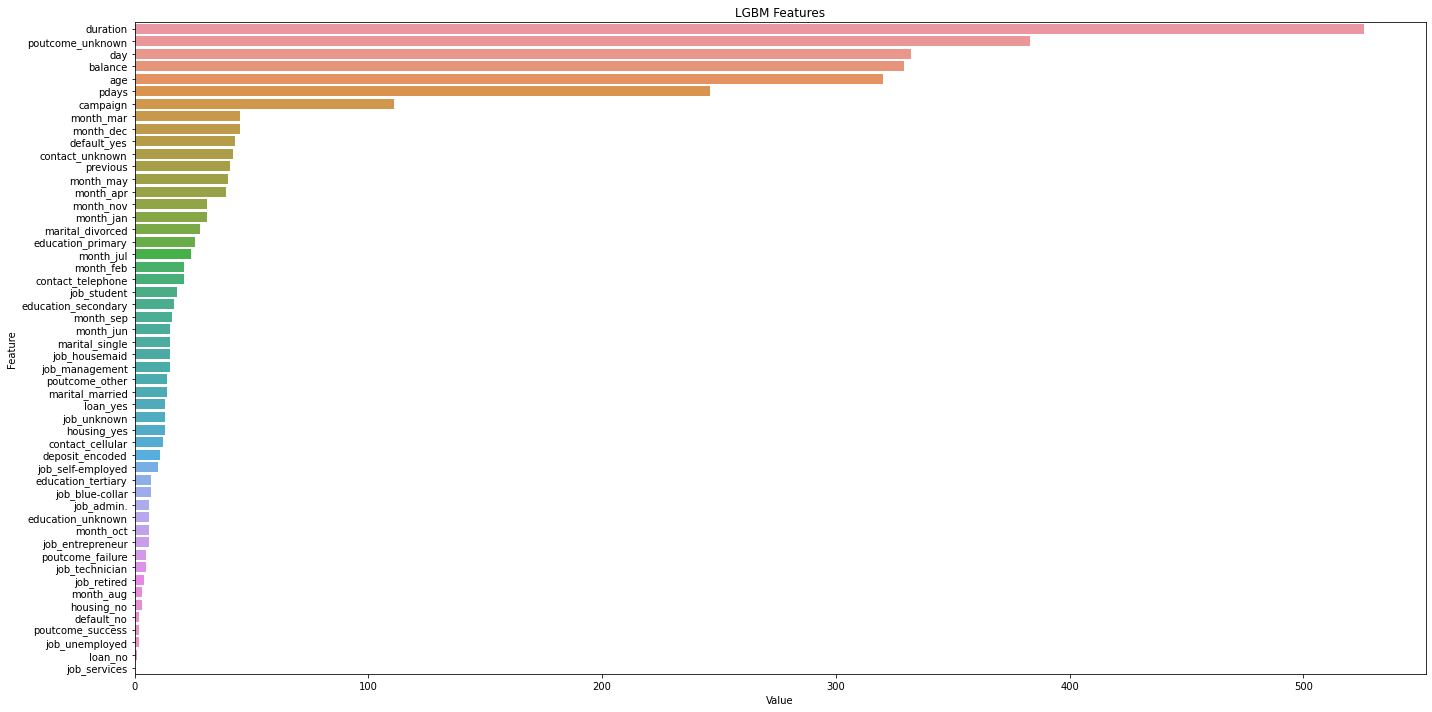

In [ ]:
model = LGBMClassifier()
model.fit(ensemble_train,y_train_over)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_clean.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
#take 10 most important feature
mask = np.argsort(models['LGBM'].feature_importances_)[::-1][:10]
mask

KeyError: ignored

In [ ]:
important_features = np.array(X_train_over.columns)[mask]
important_features

NameError: ignored

In [ ]:
X_train_over_engineered = X_train_over[important_features]
X_test_over_engineered = X_test[important_features]

In [ ]:
model = LGBMClassifier()
# model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train_over_engineered, y_train_over)

LGBMClassifier()

In [ ]:
y_pred = model.predict(X_test_over_engineered)
y_pred_proba = model.predict_proba(X_test_over_engineered)[:,1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_proba)
print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

Selecting top 10 features does not improve LGBM

## RFE feature selection

In [ ]:
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif


In [ ]:
model = LGBMClassifier()

mdl = RFE(model,n_features_to_select=10)
# mdl = SelectFromModel(model,prefit=True)
# mdl = SelectKBest(f_classif, k=10) 

mdl.fit(X_train_over,y_train_over)
ix = mdl.get_support() 

pd.DataFrame(mdl.transform(X_train_over), columns = X_train_over.columns.values[ix]).head()


,age,balance,day,duration,campaign,pdays,previous,contact_unknown,month_apr,month_may
0,-1.124080,-0.444463,8.0,-0.218088,-0.246560,-0.110178,-0.25194,0.0,0.0,0.0
1,-0.559037,-0.292726,5.0,0.069263,-0.246560,-0.110178,-0.25194,0.0,0.0,0.0
2,0.476877,-0.159709,31.0,-0.959764,0.076230,-0.110178,-0.25194,0.0,0.0,0.0
3,-0.935732,0.860085,18.0,0.108094,-0.569351,-0.110178,-0.25194,0.0,0.0,0.0
4,0.571051,0.690940,11.0,2.309822,-0.246560,-0.110178,-0.25194,0.0,0.0,0.0


In [ ]:
X_train_over_engineered = pd.DataFrame(mdl.transform(X_train_over), columns = X_train_over.columns.values[ix])
X_test_over_engineered =  pd.DataFrame(mdl.transform(X_test), columns = X_train_over.columns.values[ix])

In [ ]:
model = LGBMClassifier()

In [ ]:
model.fit(X_train_over_engineered, y_train_over)

LGBMClassifier()

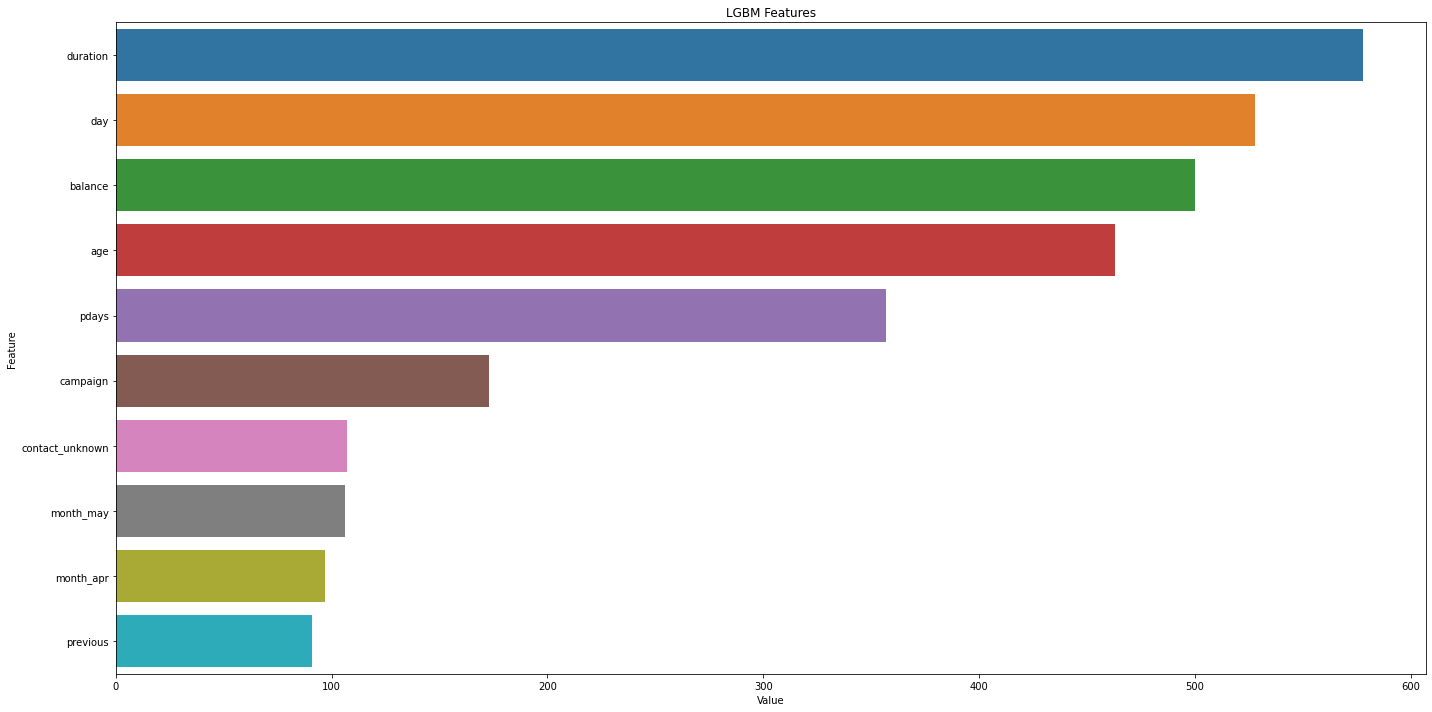

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train_over_engineered.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test_over_engineered)
y_pred_proba = model.predict_proba(X_test_over_engineered)[:,1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_proba)
print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

0.9023886759068122 0.4899845916795069 0.9125435966088963
[[11604   373]
 [  951   636]]


cannot beat original LGBM

# Tuning LGBM


In [ ]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']



In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train_over, y_train_over, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9157   |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.4615   |
|  2        |  0.9098   |  0.9964   |  0.7939   |  0.9862   |  84.63    |  12.59    |  70.77    |  12.12    |  67.99    |  0.258    |
|  3        |  0.9112   |  0.8192   |  0.8548   |  0.8278   |  56.28    |  26.84    |  54.7     |  45.01    |  62.09    |  0.4252   |
|  4        |  0.921    |  0.9281   |  0.5869   |  0.1144   |  87.62    |  23.97    |  60.78    |  32.93    |  25.48    |  0.8056   |
|  5        |  0.9145   |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |
|  6        |  0.9206   |  0.8333   |  0.7175   |  0.06083  | 

In [ ]:
opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
opt_params[1]['objective']='binary'
opt_params[1]['metric']='auc'
opt_params[1]['is_unbalance']=True
opt_params[1]['boost_from_average']=False
opt_params=opt_params[1]
opt_params

{'bagging_fraction': 1.0,
 'boost_from_average': False,
 'feature_fraction': 0.4176171690233207,
 'is_unbalance': True,
 'learning_rate': 0.1533624820318014,
 'max_bin': 83,
 'max_depth': 24,
 'metric': 'auc',
 'min_data_in_leaf': 64,
 'min_sum_hessian_in_leaf': 19.27455873795139,
 'num_leaves': 24,
 'objective': 'binary',
 'subsample': 1.0}

In [ ]:
model = LGBMClassifier(**opt_params)
model.fit(X_train_over,y_train_over)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_proba)

print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

0.8526983190799174 0.5823578595317727 0.9243348638345319
[[10173  1804]
 [  194  1393]]


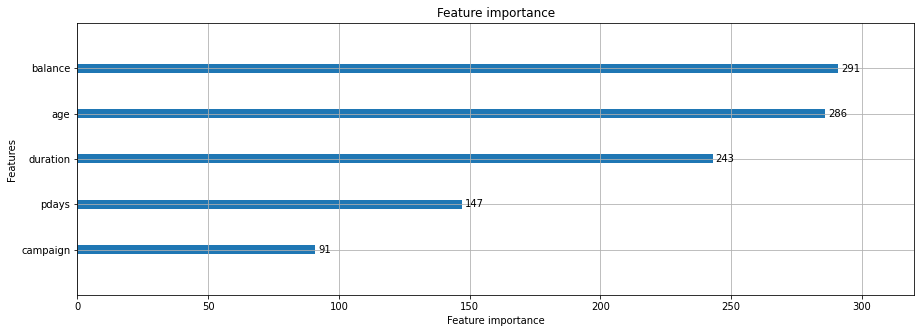

In [ ]:
lgb.plot_importance(model, figsize = (15,5), max_num_features=5)

# Build 2 classifiers:
 - one for customers who have been contacted previously
 - one for customers who have not been contacted before.

## LGBM

In [ ]:
df_clean = df.copy()

In [ ]:
df_clean.drop(columns=['day','month'], inplace=True)

In [ ]:
category_cols = df_clean.select_dtypes(include='object').columns
numeric_cols =  list(df_clean.select_dtypes(include='number').columns)

In [ ]:
for col in category_cols:
    df_clean = label_encode(df_clean, col)

In [ ]:
cols_to_clip = [
                'balance',
                'duration',
                'campaign',
                'previous',
                ]
for col in cols_to_clip:
    clip_col(df_clean, col)

In [ ]:
numeric_cols.remove('deposit_encoded')
scaler = StandardScaler()
for col in numeric_cols:
    if col != 'pdays':
        df_clean[[col]] = scaler.fit_transform(df_clean[[col]])

In [ ]:
X = df_clean.drop(columns='deposit_encoded')
y = df_clean['deposit_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=620, stratify=y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
is_balanced = True
if not is_balanced:
    sampler = RandomOverSampler()
    X_train_over, y_train_over = sampler.fit_resample(X_train, y_train)
else:
    X_train_over, y_train_over = X_train, y_train

In [ ]:
X_train_over_new_contact = X_train_over[X_train_over['pdays']==-1]
X_train_over_old_contact = X_train_over[X_train_over['pdays']!=-1]
y_train_over_new_contact = y_train_over[X_train_over_new_contact.index]
y_train_over_old_contact = y_train_over[X_train_over_old_contact.index]

In [ ]:
X_test_new_contact = X_test[X_test['pdays']==-1]
X_test_old_contact = X_test[X_test['pdays']!=-1]
y_test_new_contact = y_test[X_test_new_contact.index]
y_test_old_contact = y_test[X_test_old_contact.index]
y_test_all_contact = np.concatenate([y_test_new_contact, y_test_old_contact])

In [ ]:
model = LGBMClassifier()
model.fit(X_train_over_new_contact,y_train_over_new_contact)
y_pred_new_contact = model.predict(X_test_new_contact)
y_pred_proba_new_contact = model.predict_proba(X_test_new_contact)[:,1]

In [ ]:
model = LGBMClassifier()
model.fit(X_train_over_old_contact,y_train_over_old_contact)
y_pred_old_contact = model.predict(X_test_old_contact)
y_pred_proba_old_contact = model.predict_proba(X_test_old_contact)[:,1]

In [ ]:
y_pred = np.concatenate([y_pred_new_contact, y_pred_old_contact])
y_pred_proba = np.concatenate([y_pred_proba_new_contact, y_pred_proba_old_contact])

In [ ]:
accuracy = accuracy_score(y_test_all_contact, y_pred)
f1 = f1_score(y_test_all_contact, y_pred)
roc_score = roc_auc_score(y_test_all_contact, y_pred_proba)

print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

0.9036419935122383 0.49399922570654275 0.9047859742094423
[[11104   873]
 [ 1464   123]]


Similar ROC score

## Simple LR - improve base model
using split pdays dataset

In [ ]:
df_clean = df.copy()

In [ ]:
#df_clean.drop(columns=['day','month'], inplace=True)

In [ ]:
category_cols = df_clean.select_dtypes(include='object').columns
numeric_cols =  list(df_clean.select_dtypes(include='number').columns)

In [ ]:
for col in category_cols:
    df_clean = ohe(df_clean, col)

In [ ]:
cols_to_clip = [
                'balance',
                'duration',
                'campaign',
                'previous',
                ]
for col in cols_to_clip:
    clip_col(df_clean, col)

In [ ]:
numeric_cols.remove('deposit_encoded')
scaler = StandardScaler()
for col in numeric_cols:
    if col != 'pdays':
        df_clean[[col]] = scaler.fit_transform(df_clean[[col]])

In [ ]:
X = df_clean.drop(columns='deposit_encoded')
y = df_clean['deposit_encoded']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=620, stratify=y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
is_balanced = True
if not is_balanced:
    sampler = RandomOverSampler()
    X_train_over, y_train_over = sampler.fit_resample(X_train, y_train)
else:
    X_train_over, y_train_over = X_train, y_train

In [ ]:
X_train_over_new_contact = X_train_over[X_train_over['pdays']==-1]
X_train_over_old_contact = X_train_over[X_train_over['pdays']!=-1]
y_train_over_new_contact = y_train_over[X_train_over_new_contact.index]
y_train_over_old_contact = y_train_over[X_train_over_old_contact.index]

In [ ]:
X_test_new_contact = X_test[X_test['pdays']==-1]
X_test_old_contact = X_test[X_test['pdays']!=-1]
y_test_new_contact = y_test[X_test_new_contact.index]
y_test_old_contact = y_test[X_test_old_contact.index]
y_test_all_contact = np.concatenate([y_test_new_contact, y_test_old_contact])

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_over_new_contact,y_train_over_new_contact)
y_pred_new_contact = model.predict(X_test_new_contact)
y_pred_proba_new_contact = model.predict_proba(X_test_new_contact)[:,1]

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_over_old_contact,y_train_over_old_contact)
y_pred_old_contact = model.predict(X_test_old_contact)
y_pred_proba_old_contact = model.predict_proba(X_test_old_contact)[:,1]

In [ ]:
y_pred = np.concatenate([y_pred_new_contact, y_pred_old_contact])
y_pred_proba = np.concatenate([y_pred_proba_new_contact, y_pred_proba_old_contact])

In [ ]:
accuracy = accuracy_score(y_test_all_contact, y_pred)
f1 = f1_score(y_test_all_contact, y_pred)
roc_score = roc_auc_score(y_test_all_contact, y_pred_proba)

print(accuracy, f1, roc_score)
print(confusion_matrix(y_test, y_pred))

0.9020200530816869 0.4505994212484497 0.9052039408235665
[[11257   720]
 [ 1475   112]]


Better than Random Forest!

## Decision Tree - improve base model

using split pdays dataset

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_over_old_contact,y_train_over_old_contact)
y_pred_old_contact_dt = dt_model.predict(X_test_old_contact)
y_pred_proba_old_contact_dt = dt_model.predict_proba(X_test_old_contact)[:,1]

dt_model.fit(X_train_over_new_contact,y_train_over_new_contact)
y_pred_new_contact_dt = dt_model.predict(X_test_new_contact)
y_pred_proba_new_contact_dt = dt_model.predict_proba(X_test_new_contact)[:,1]

In [ ]:
y_pred_dt = np.concatenate([y_pred_new_contact_dt, y_pred_old_contact_dt])
y_pred_proba_dt = np.concatenate([y_pred_proba_new_contact_dt, y_pred_proba_old_contact_dt])

accuracy_dt = accuracy_score(y_test_all_contact, y_pred_dt)
f1 = f1_score(y_test_all_contact, y_pred_dt)
roc_score = roc_auc_score(y_test_all_contact, y_pred_proba_dt)

print(accuracy_dt, f1, roc_score)
print(confusion_matrix(y_test, y_pred_dt))

0.8752580359775878 0.4689265536723164 0.699781544115825
[[10571  1406]
 [ 1394   193]]


## SVM - improve base model

Using split pdays dataset

In [ ]:
svc_model = SVC(probability=True)
svc_model.fit(X_train_over_old_contact,y_train_over_old_contact)
y_pred_old_contact_svc = svc_model.predict(X_test_old_contact)
y_pred_proba_old_contact_svc = svc_model.predict_proba(X_test_old_contact)[:,1]

svc_model.fit(X_train_over_new_contact,y_train_over_new_contact)
y_pred_new_contact_svc = svc_model.predict(X_test_new_contact)
y_pred_proba_new_contact_svc = svc_model.predict_proba(X_test_new_contact)[:,1]

In [ ]:
y_pred_svc = np.concatenate([y_pred_new_contact_svc, y_pred_old_contact_svc])
y_pred_proba_svc = np.concatenate([y_pred_proba_new_contact_svc, y_pred_proba_old_contact_svc])

accuracy_svc = accuracy_score(y_test_all_contact, y_pred_svc)
f1 = f1_score(y_test_all_contact, y_pred_svc)
roc_score = roc_auc_score(y_test_all_contact, y_pred_proba_svc)

print(accuracy_svc, f1, roc_score)
print(confusion_matrix(y_test, y_pred_svc))

# Conclusion:

Finetuned engineered LGBM > engineered LGBM > out-of-box LGBM = Feature engineered Logistic Regression> Random Forest > Logistic, SVM > DT